In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from IPython.display import Image
from matplotlib import pyplot as plt
from apng import APNG
import shutil
from shapely.geometry import shape
from shapely.ops import unary_union
import fiona
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer
from shutil import copyfile

%matplotlib inline

In [4]:
pd.options.display.max_columns = 100

In [5]:
df = pd.read_csv('encuesta_corr.csv', error_bad_lines=False)
zat = pd.read_csv('zat.csv', sep=";")

In [6]:
df['hora1_inicio'] = pd.to_datetime(df['HORA_INICIO'], format='%H:%M:%S').dt.hour
df['hora1_fin'] = pd.to_datetime(df['HORA_FIN'], format='%H:%M:%S').dt.hour



### RATE MOVILITY PER HOUR - ONLY TAXIS IN BOGOTÀ

In [7]:
df1 = df[df.MEDIO_PREDOMINANTE == 'TAXI'] 
df2 = df1[df1.MUNICIPIO_ORIGEN == 'BOGOTA-DC 11001']
rohit = pd.DataFrame(df2['hora1_inicio'].value_counts())
rohft = pd.DataFrame(df2['hora1_fin'].value_counts())
rohit.rename(columns={'hora1_inicio':'count_inicio_taxi'}, inplace=True)
rohft.rename(columns={'hora1_fin':'count_fin_taxi'}, inplace=True)
rohit['count_fin_taxi'] = rohft.count_fin_taxi
roht = rohit
roht['% inicio'] = (roht.count_inicio_taxi / len(df2)) * 100 
roht['% fin'] = (roht.count_fin_taxi / len(df2)) * 100 
roht

,count_inicio_taxi,count_fin_taxi,% inicio,% fin
12.0,319,251,8.025157,6.314465
17.0,294,218,7.396226,5.484277
6.0,272,177,6.842767,4.452830
15.0,271,243,6.817610,6.113208
7.0,254,240,6.389937,6.037736
10.0,239,233,6.012579,5.861635
8.0,238,260,5.987421,6.540881
9.0,235,253,5.911950,6.364780
11.0,228,250,5.735849,6.289308
18.0,225,230,5.660377,5.786164


In [8]:
x_max_r = -74.019
x_min_r = -74.215
y_min_r = 4.522
y_max_r = 4.755

df2.y_coord_org = ((df2.y_coord_org - y_min_r)/(y_max_r - y_min_r))*30
df2.x_coord_org = ((df2.x_coord_org - x_min_r)/(x_max_r - x_min_r))*30


C:\Users\danpa\Anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [9]:
file_infofile_in  = fiona.open("../csv/shp/Bogota_sencillo/New_Shapefile.shp")

y = set()
x = set()
lengths = set()

nodes = set()
edges = set()
edges_prime = set()

nodes_norm = list()
edges_norm = set()

for line in file_infofile_in:
    for node in line['geometry']['coordinates']:
        nodes.add((round(node[0],3),round(node[1],3)))
        x.add(round(node[0],3))
        y.add(round(node[1],3))

nodes = list(nodes)

# Getting the max and min for x and y axis
x_max = max(x)
x_min = min(x)
y_max = max(y)
y_min = min(y)

df3 = pd.DataFrame(data=[[x_min,x_max,y_min,y_max]], columns=['x_min','x_max','y_min','y_max'])
#df3.to_csv('../distributions/boundaries.csv', index=False)

# Normalizing

for node in nodes:
    node_norm = (nodes.index(node), [(node[0]-x_min)/(x_max-x_min),(node[1]-y_min)/(y_max-y_min)])
    nodes_norm.append(node_norm)
    
nodes_norm = [(item[0], [round(item[1][0],3), round(item[1][1],3)]) for item in nodes_norm]

for line in file_infofile_in:
    last_coord = None
    for coord in line['geometry']['coordinates']:
        if last_coord != None:
            length = ((coord[0]-last_coord[0])**2+(coord[1]-last_coord[1])**2)**0.5
            edge = ((nodes.index((round(last_coord[0],3),round(last_coord[1],3))),nodes.index((round(coord[0],3),round(coord[1],3)))),length,line['properties']['Id'])
            edges.add(edge)
        last_coord = coord
        
    
edges = [edge for edge in edges if edge[0][1] != edge[0][0]]

length_max = max(list(zip(*edges))[1])
length_min = min(list(zip(*edges))[1])

# normalizing length
edges_norm = [(edges.index(edge),edge[0],(edge[1]-length_min)/(length_max-length_min),edge[2]) for edge in edges]

coords = []

for coord in list(zip(*edges))[0]:
    coord1 = (nodes[coord[0]], nodes[coord[1]])
    coords.append(coord1)
    
coords

[((600570.841, 10514335.844), (601042.94, 10514969.907)),
 ((604481.336, 10517647.98), (604741.068, 10517556.703)),
 ((604939.3, 10513313.715), (604532.388, 10513096.414)),
 ((605180.494, 10521555.059), (605627.173, 10521413.259)),
 ((602994.616, 10509701.625), (599413.747, 10504463.937)),
 ((605381.078, 10522676.013), (605856.672, 10522715.384)),
 ((598321.544, 10515929.426), (600218.173, 10518231.739)),
 ((605906.741, 10519212.831), (606374.491, 10520109.82)),
 ((600218.173, 10518231.739), (601511.309, 10516774.051)),
 ((603435.997, 10516453.671), (604136.795, 10515722.67)),
 ((598927.387, 10503053.02), (599946.365, 10502651.603)),
 ((607328.774, 10522294.544), (608292.63, 10522036.656)),
 ((600440.573, 10509948.801), (601751.975, 10508853.314)),
 ((602141.78, 10514268.512), (603732.523, 10513569.371)),
 ((597663.557, 10520294.865), (598898.18, 10519215.758)),
 ((606808.006, 10517274.967), (605478.308, 10518006.134)),
 ((600144.004, 10512572.664), (600621.793, 10511292.558)),
 ((6060

## 1 Blocks of the day (6 hours)

In [10]:
early_morning = df2.loc[(df2.hora1_inicio >= 0) & (df2.hora1_inicio < 6)]
morning = df2.loc[(df2.hora1_inicio >= 6) & (df2.hora1_inicio < 12)]
late = df2.loc[(df2.hora1_inicio >= 12) & (df2.hora1_inicio < 18)]
night = df2.loc[(df2.hora1_inicio >= 18) & (df2.hora1_inicio < 24)]

In [11]:
early_morning_av = df2.loc[(df2.hora1_fin >= 0) & (df2.hora1_fin < 6)]
morning_av = df2.loc[(df2.hora1_fin >= 6) & (df2.hora1_fin < 12)]
late_av = df2.loc[(df2.hora1_fin >= 12) & (df2.hora1_fin < 18)]
night_av = df2.loc[(df2.hora1_fin >= 18) & (df2.hora1_fin < 24)]

## Distribution x_cord_org VS y_cord_org by Blocks 

### - Early_morning

--------------------------------------ORIGIN--------------------------------------


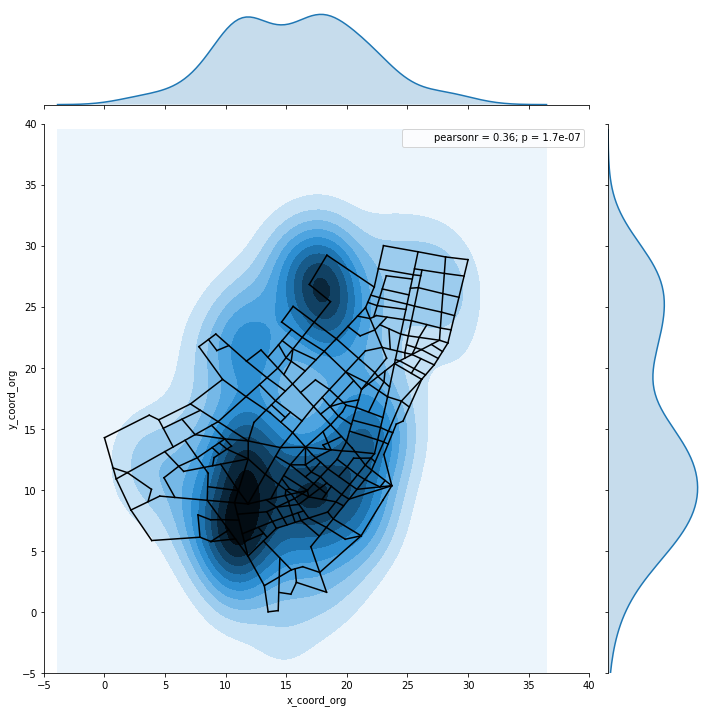

In [12]:
print('--------------------------------------ORIGIN--------------------------------------')
plot = sns.jointplot(x="x_coord_org", y="y_coord_org", data=early_morning, kind="kde", size=10, xlim=(-5,40), ylim=(-5,40))
#plt.show()
for i in coords:
    
    plot.ax_joint.plot([(((coords[coords.index(i)][0][0])-x_min)/(x_max-x_min))*30,(((coords[coords.index(i)][1][0])-x_min)/(x_max-x_min))*30],[(((coords[coords.index(i)][0][1])-y_min)/(y_max-y_min))*30,(((coords[coords.index(i)][1][1])-y_min)/(y_max-y_min))*30],'black')


--------------------------------------ARRIVE--------------------------------------


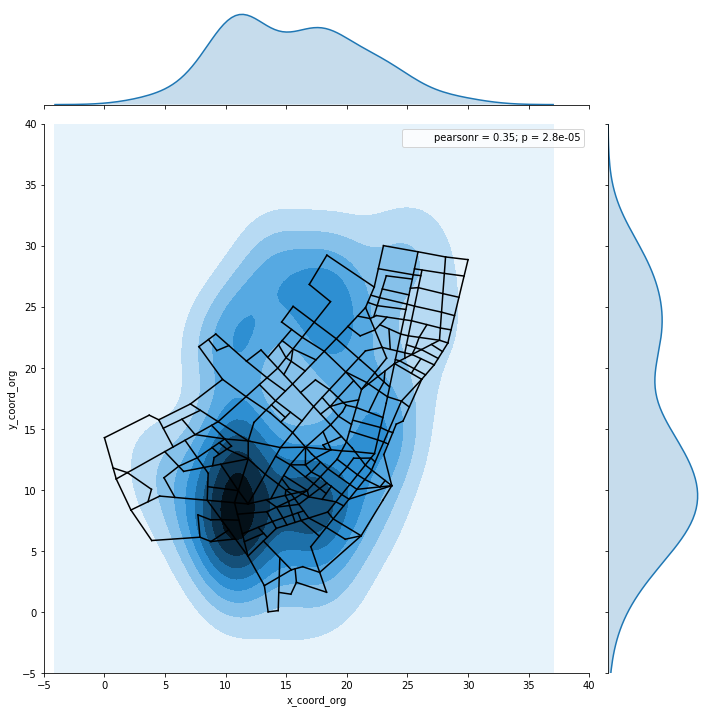

In [13]:
# EARLY MORNING
print ('--------------------------------------ARRIVE--------------------------------------')
plot = sns.jointplot(x="x_coord_org", y="y_coord_org", data=early_morning_av, kind="kde", size=10, xlim=(-5,40), ylim=(-5,40))
#plt.show()
for i in coords:
    
    plot.ax_joint.plot([(((coords[coords.index(i)][0][0])-x_min)/(x_max-x_min))*30,(((coords[coords.index(i)][1][0])-x_min)/(x_max-x_min))*30],[(((coords[coords.index(i)][0][1])-y_min)/(y_max-y_min))*30,(((coords[coords.index(i)][1][1])-y_min)/(y_max-y_min))*30],'black')


### - Morning

--------------------------------------ORIGIN--------------------------------------


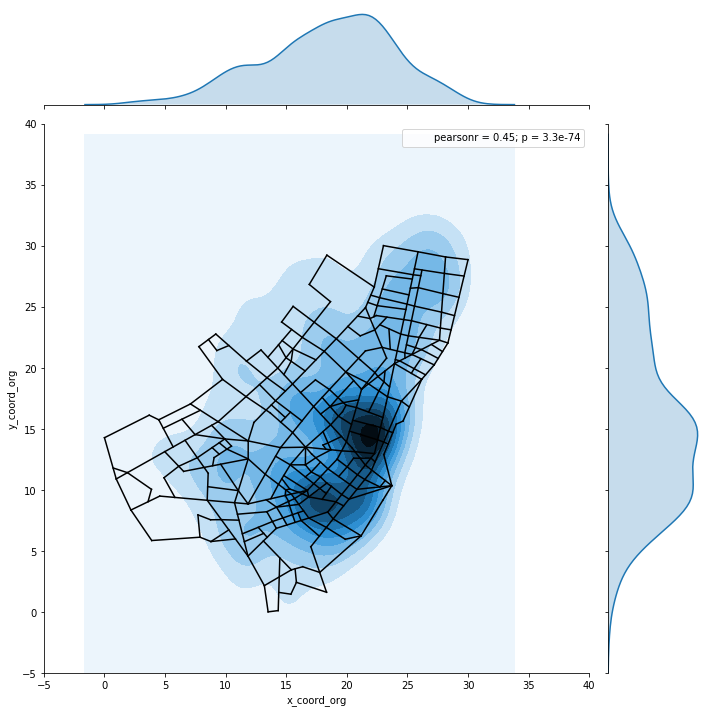

In [14]:
print('--------------------------------------ORIGIN--------------------------------------')
plot = sns.jointplot(x="x_coord_org", y="y_coord_org", data=morning, kind="kde", size=10, xlim=(-5,40), ylim=(-5,40))
#plt.show()
for i in coords:
    
    plot.ax_joint.plot([(((coords[coords.index(i)][0][0])-x_min)/(x_max-x_min))*30,(((coords[coords.index(i)][1][0])-x_min)/(x_max-x_min))*30],[(((coords[coords.index(i)][0][1])-y_min)/(y_max-y_min))*30,(((coords[coords.index(i)][1][1])-y_min)/(y_max-y_min))*30],'black')


--------------------------------------ARRIVE--------------------------------------


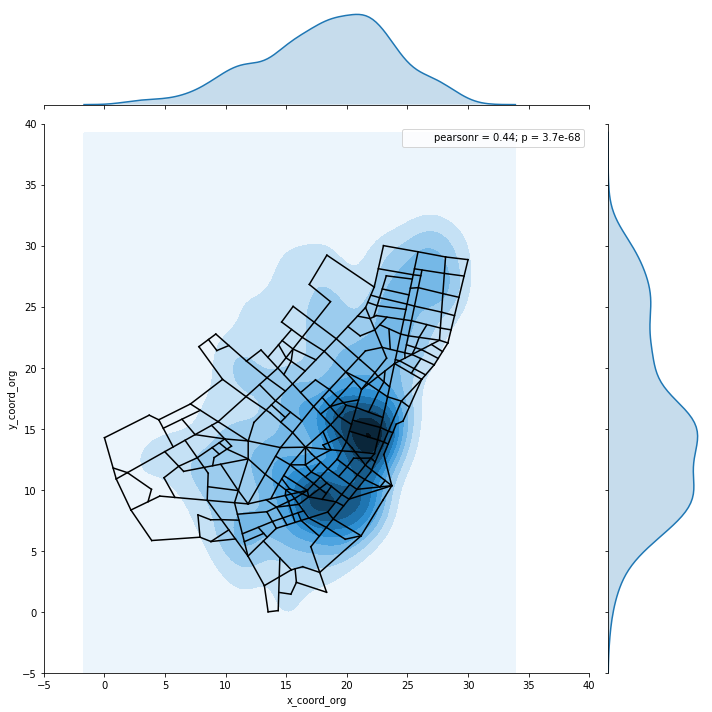

In [15]:
print('--------------------------------------ARRIVE--------------------------------------')
# MORNING
plot = sns.jointplot(x="x_coord_org", y="y_coord_org", data=morning_av, kind="kde", size=10, xlim=(-5,40), ylim=(-5,40))
#plt.show()
for i in coords:
    
    plot.ax_joint.plot([(((coords[coords.index(i)][0][0])-x_min)/(x_max-x_min))*30,(((coords[coords.index(i)][1][0])-x_min)/(x_max-x_min))*30],[(((coords[coords.index(i)][0][1])-y_min)/(y_max-y_min))*30,(((coords[coords.index(i)][1][1])-y_min)/(y_max-y_min))*30],'black')


### - Late

--------------------------------------ORIGIN--------------------------------------


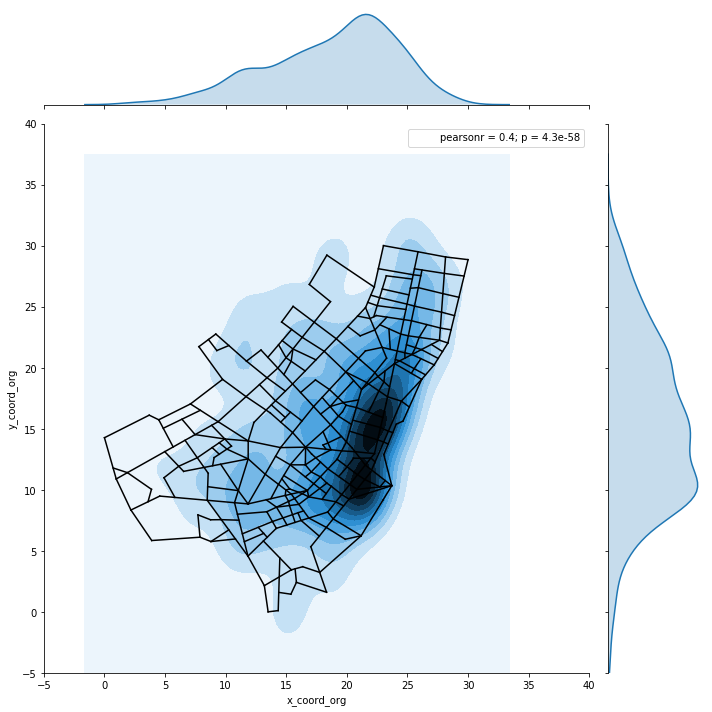

In [16]:
print('--------------------------------------ORIGIN--------------------------------------')
plot = sns.jointplot(x="x_coord_org", y="y_coord_org", data=late, kind="kde", size=10, xlim=(-5,40), ylim=(-5,40))
#plt.show()
for i in coords:
    
    plot.ax_joint.plot([(((coords[coords.index(i)][0][0])-x_min)/(x_max-x_min))*30,(((coords[coords.index(i)][1][0])-x_min)/(x_max-x_min))*30],[(((coords[coords.index(i)][0][1])-y_min)/(y_max-y_min))*30,(((coords[coords.index(i)][1][1])-y_min)/(y_max-y_min))*30],'black')


--------------------------------------ARRIVE--------------------------------------


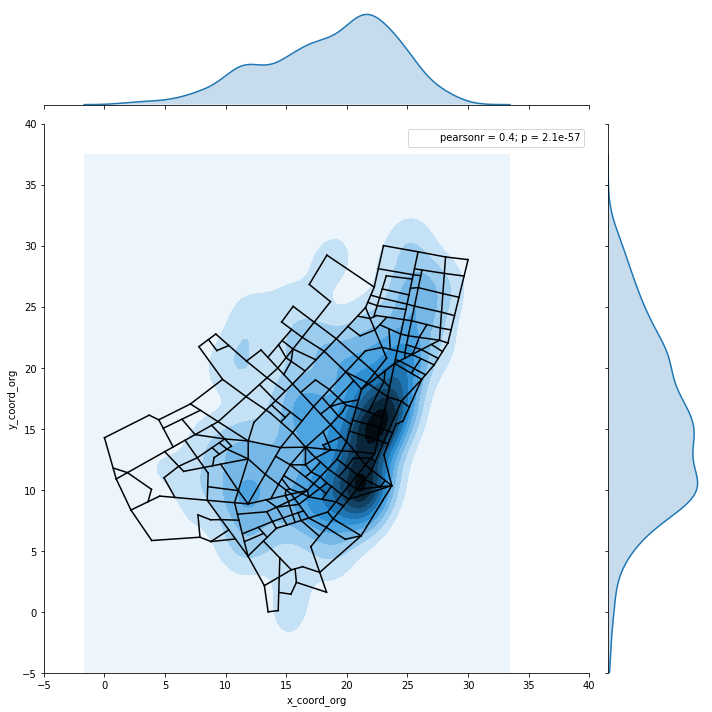

In [17]:
print('--------------------------------------ARRIVE--------------------------------------')
# LATE
plot = sns.jointplot(x="x_coord_org", y="y_coord_org", data=late_av, kind="kde", size=10, xlim=(-5,40), ylim=(-5,40))
#plt.show()
for i in coords:
    
    plot.ax_joint.plot([(((coords[coords.index(i)][0][0])-x_min)/(x_max-x_min))*30,(((coords[coords.index(i)][1][0])-x_min)/(x_max-x_min))*30],[(((coords[coords.index(i)][0][1])-y_min)/(y_max-y_min))*30,(((coords[coords.index(i)][1][1])-y_min)/(y_max-y_min))*30],'black')


### - Night

--------------------------------------ORIGIN--------------------------------------


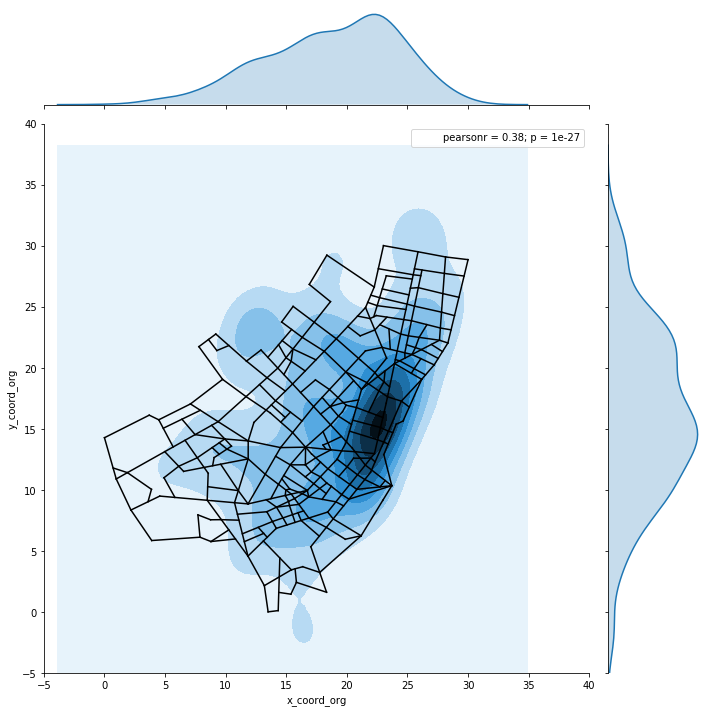

In [18]:
print('--------------------------------------ORIGIN--------------------------------------')
plot = sns.jointplot(x="x_coord_org", y="y_coord_org", data=night, kind="kde", size=10, xlim=(-5,40), ylim=(-5,40))
#plt.show()
for i in coords:
    
    plot.ax_joint.plot([(((coords[coords.index(i)][0][0])-x_min)/(x_max-x_min))*30,(((coords[coords.index(i)][1][0])-x_min)/(x_max-x_min))*30],[(((coords[coords.index(i)][0][1])-y_min)/(y_max-y_min))*30,(((coords[coords.index(i)][1][1])-y_min)/(y_max-y_min))*30],'black')



--------------------------------------ARRIVE--------------------------------------


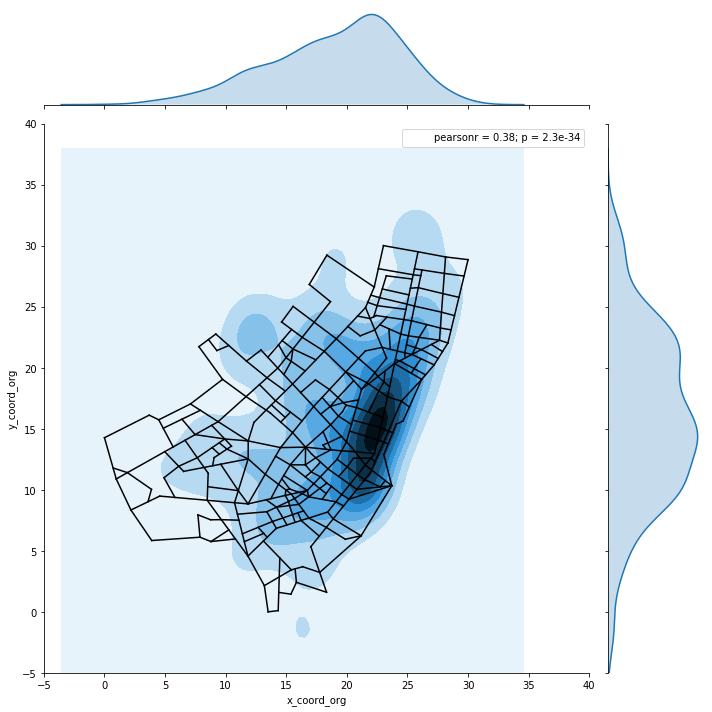

In [19]:
print('--------------------------------------ARRIVE--------------------------------------')
# NIGHT
plot = sns.jointplot(x="x_coord_org", y="y_coord_org", data=night_av, kind="kde", size=10, xlim=(-5,40), ylim=(-5,40))
#plt.show()
for i in coords:
    
    plot.ax_joint.plot([(((coords[coords.index(i)][0][0])-x_min)/(x_max-x_min))*30,(((coords[coords.index(i)][1][0])-x_min)/(x_max-x_min))*30],[(((coords[coords.index(i)][0][1])-y_min)/(y_max-y_min))*30,(((coords[coords.index(i)][1][1])-y_min)/(y_max-y_min))*30],'black')


## GIF

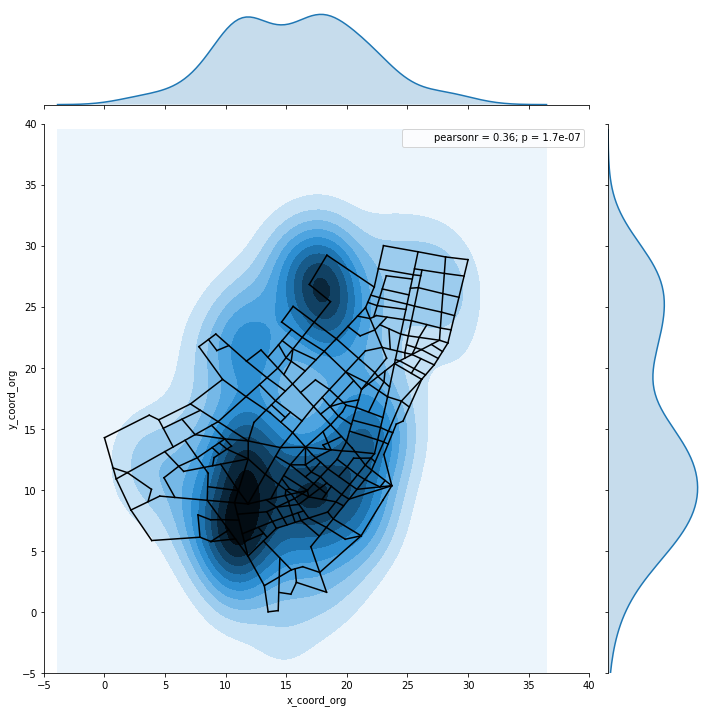

In [52]:

from os import walk
def ls(ruta = str('imgs/Bivariate graphs/Time Blocks/Origin')):

    return next(walk(ruta))[2]

images_people = ls()
images_people


for m in images_people:                           
    img = str(str('imgs/Bivariate graphs/Time Blocks/Origin/' + m))      
    img
    graphs = images_people
    graphs[int(images_people.index(m))] = img                        

APNG.from_files(graphs, delay = 400).save(str('imgs/Bivariate graphs/Time Blocks/Origin/GIF_ORI.png'))
Image(filename = str('imgs/Bivariate graphs/Time Blocks/Origin/GIF_ORI.png'))

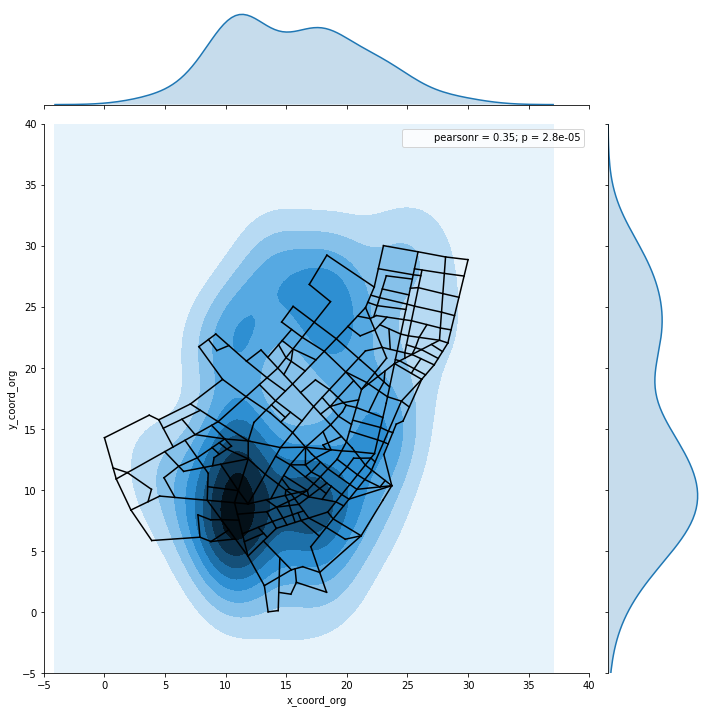

In [54]:
#print('--------------------------------------ARRIVE--------------------------------------')
def ls(ruta = str('imgs/Bivariate graphs/Time Blocks/Arrive')):

    return next(walk(ruta))[2]

images_people = ls()
images_people


for m in images_people:                           
    img = str(str('imgs/Bivariate graphs/Time Blocks/Arrive/' + m))      
    img
    graphs = images_people
    graphs[int(images_people.index(m))] = img                        

APNG.from_files(graphs, delay = 400).save(str('imgs/Bivariate graphs/Time Blocks/Arrive/GIF_ARR.png'))
Image(filename = str('imgs/Bivariate graphs/Time Blocks/Arrive/GIF_ARR.png'))

In [35]:
m1 = df2.loc[(((df2.hora1_inicio >= 0) & (df2.hora1_inicio < 6)) + ((df2.hora1_inicio >= 20) & (df2.hora1_inicio < 24)))]
m2 = df2.loc[(df2.hora1_inicio >= 6) & (df2.hora1_inicio < 13)]
m3 = df2.loc[(df2.hora1_inicio >= 13) & (df2.hora1_inicio < 19)]
night = df2.loc[(df2.hora1_inicio >= 18) & (df2.hora1_inicio < 24)]

C:\Users\danpa\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [55]:
m1_av = pd.DataFrame(df2.loc[(df2.hora1_fin >= 0) & (df2.hora1_fin < 6)]).plot(kind='bar', title='ARRIVE: Taxis')
m2_av = pd.DataFrame(df2.loc[(df2.hora1_fin >= 6) & (df2.hora1_fin < 14)]).plot(kind='bar', title='ARRIVE: Taxis')
m3_av = pd.DataFrame(df2.loc[(df2.hora1_fin >= 14) & (df2.hora1_fin < 20)]).plot(kind='bar', title='ARRIVE: Taxis')
m4_av = pd.DataFrame(df2.loc[(df2.hora1_fin >= 20) & (df2.hora1_fin < 24)])..plot(kind='bar', title='ARRIVE: Taxis')

SyntaxError: invalid syntax (<ipython-input-55-1099551fe371>, line 4)

In [58]:
m1_av = pd.DataFrame(df2.loc[(df2.hora1_fin >= 0) & (df2.hora1_fin < 6)])
roh = pd.DataFrame(df2.hora1_inicio.value_counts(dropna=False, normalize=False)).plot(kind='bar', title='ORIGIN: Taxis vs Hour')


--------------------------------------ORIGIN--------------------------------------


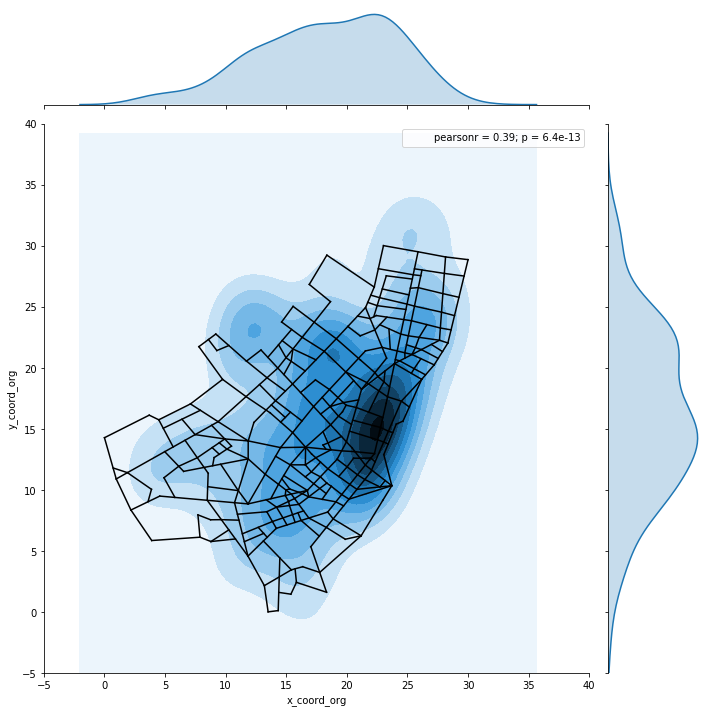

In [49]:
print('--------------------------------------ORIGIN--------------------------------------')
plot = sns.jointplot(x="x_coord_org", y="y_coord_org", data=m4_av, kind="kde", size=10, xlim=(-5,40), ylim=(-5,40))
#plt.show()
for i in coords:
    
    plot.ax_joint.plot([(((coords[coords.index(i)][0][0])-x_min)/(x_max-x_min))*30,(((coords[coords.index(i)][1][0])-x_min)/(x_max-x_min))*30],[(((coords[coords.index(i)][0][1])-y_min)/(y_max-y_min))*30,(((coords[coords.index(i)][1][1])-y_min)/(y_max-y_min))*30],'black')

